In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bigram = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(2, 2))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bigram = vectorizer_bigram.fit_transform(list(s)).toarray()
df_bigram = pd.DataFrame(data = X_bigram, columns = vectorizer_bigram.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Jaccard-bigram'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bigram.loc[indexes_train_1].values
X_train['stack_2'] = df_bigram.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bigram.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bigram.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

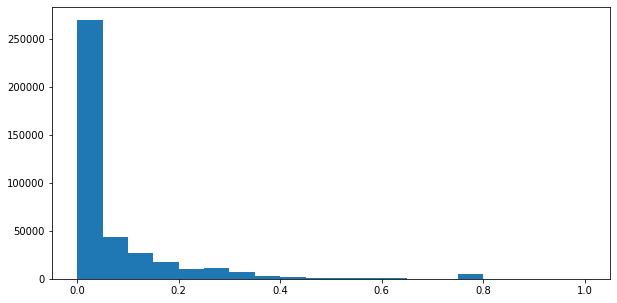

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

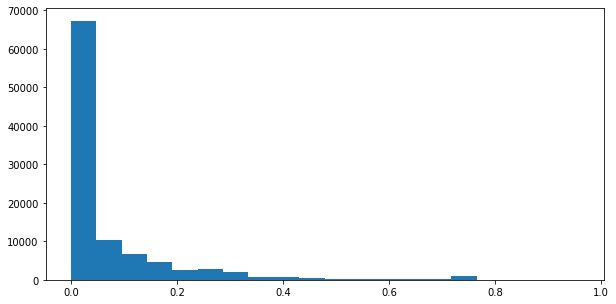

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = False)

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 47s 48ms/step - loss: 0.0046 - ham_dist_loss: 0.0044 - prod_vec_loss: 0.0135 - prod_vec_1_loss: 0.0133 - sum_vec_loss: 1.5464e-04 - sum_vec_1_loss: 1.4058e-04 - ham_dist_rmse: 0.0665 - ham_dist_mae: 0.0211 - val_loss: 7.7096e-04 - val_ham_dist_loss: 7.0546e-04 - val_prod_vec_loss: 0.0035 - val_prod_vec_1_loss: 0.0034 - val_sum_vec_loss: 6.6544e-05 - val_sum_vec_1_loss: 6.7106e-05 - val_ham_dist_rmse: 0.0266 - val_ham_dist_mae: 0.0115
Epoch 2/20
781/781 [==============================] - 36s 46ms/step - loss: 5.9679e-04 - ham_dist_loss: 5.4949e-04 - prod_vec_loss: 0.0026 - prod_vec_1_loss: 0.0025 - sum_vec_loss: 6.5775e-05 - sum_vec_1_loss: 6.7069e-05 - ham_dist_rmse: 0.0234 - ham_dist_mae: 0.0101 - val_loss: 5.5273e-04 - val_ham_dist_loss: 5.2066e-04 - val_prod_vec_loss: 0.0020 - val_prod_vec_1_loss: 0.0020 - val_sum_vec_loss: 7.1325e-05 - val_sum_vec_1_loss: 7.2668e-05 - val_ham_dist_rmse: 0.0228 - val_ham_dist_mae: 0.0096
Epoch 3/

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

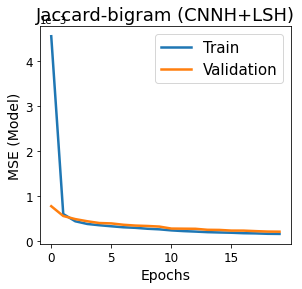

In [21]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Jaccard-bigram (CNNH+LSH)', fontsize = 18)
plt.ylabel('MSE (Model)', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')

#### 3.1.2. RMSE of LSH preserving loss

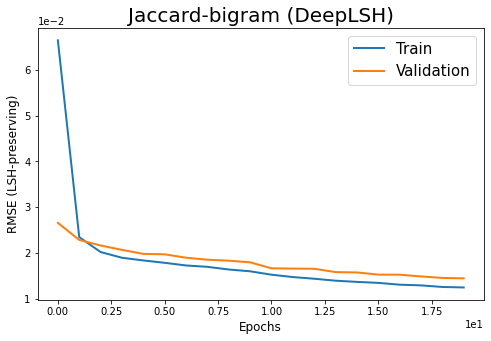

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Jaccard-bigram (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

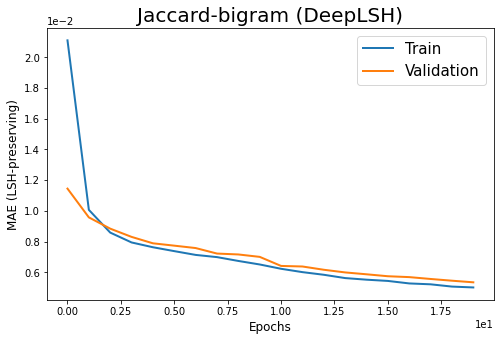

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Jaccard-bigram (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.076, 0.   , 0.016, 0.063, 0.   , 0.   , 0.   ,
       0.   , 0.128, 0.172, 0.   , 0.001, 0.765, 0.   , 0.   , 0.125,
       0.047, 0.   , 0.062, 0.104, 0.187, 0.19 , 0.   , 0.141, 0.026,
       0.255, 0.   , 0.   , 0.   , 0.08 , 0.063, 0.   , 0.   , 0.   ,
       0.094, 0.078, 0.   , 0.   , 0.   ], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.073, 0.   , 0.031, 0.073, 0.   , 0.   , 0.   ,
       0.   , 0.15 , 0.167, 0.   , 0.   , 0.765, 0.   , 0.   , 0.125,
       0.042, 0.   , 0.056, 0.097, 0.179, 0.231, 0.   , 0.129, 0.024,
       0.259, 0.   , 0.   , 0.   , 0.088, 0.07 , 0.   , 0.   , 0.   ,
       0.103, 0.097, 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

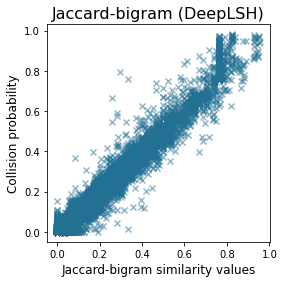

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Jaccard-bigram (DeepLSH)', fontsize = 16)
plt.xlabel("Jaccard-bigram similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Jaccard-bigram-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.901021805902414

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8403960983319045

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [33]:
intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
'First 64 bits'
intermediate_model.predict(df_bigram.iloc[[10]])[0][:64]

array([ 1.        ,  1.        ,  1.        , -1.        , -1.        ,
        1.        ,  1.        , -1.        ,  1.        , -1.        ,
        1.        , -1.        , -1.        ,  1.        , -1.        ,
        1.        ,  1.        ,  1.        , -1.        ,  1.        ,
       -1.        , -1.        ,  0.99999964,  1.        , -1.        ,
        1.        , -1.        ,  1.        , -1.        , -1.        ,
        1.        ,  1.        ,  0.99999976,  1.        ,  1.        ,
        1.        ,  1.        , -1.        , -0.9999994 ,  1.        ,
        1.        ,  1.        , -1.        ,  1.        , -1.        ,
        1.        ,  1.        , -0.99999917,  1.        , -1.        ,
       -1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        1.        , -1.        ,  1.        , -1.        ,  1.        ,
       -1.        ,  1.        , -0.9998575 ,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bigram)

In [36]:
hash_vectors

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [ 1.        , -1.        , -1.        , ...,  1.        ,
        -1.        ,  1.        ],
       [-1.        ,  1.        ,  1.        , ..., -1.        ,
         1.        , -0.9999981 ],
       [-1.        ,  1.        , -1.        , ...,  0.99999964,
        -1.        , -1.        ]], dtype=float32)

In [37]:
np.mean(np.abs(hash_vectors))

0.9906523

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [38]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.8417099609375

### 3.3.4. Comparison between approximate hamming and real hamming

In [39]:
del X_train

In [40]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

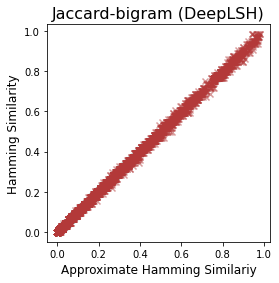

In [41]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Jaccard-bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Jaccard-bigram-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [42]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [43]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)

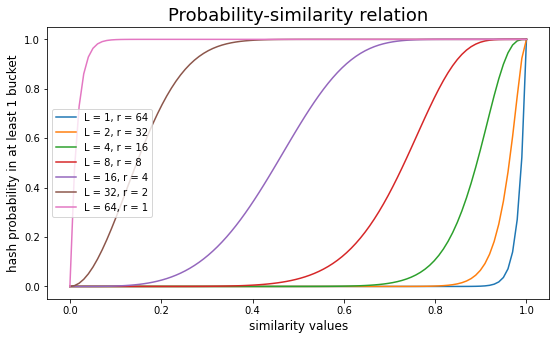

In [44]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [45]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Jaccard-bigram', trace = False)

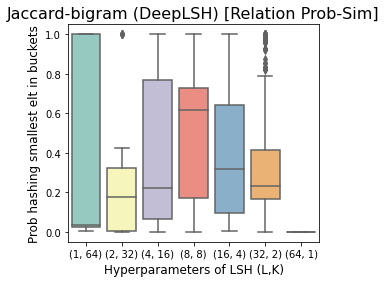

In [46]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Jaccard-bigram (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Jaccard-bigram-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [47]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

### 4.1.1. Mean and Median probability for all stack traces for a the best combination of $K$ and $L$

In [48]:
df_probLSH.mean()['(8, 8)']

0.5048254624462695

In [49]:
df_probLSH.median()['(8, 8)']

0.6187453627225242

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [50]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [51]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [73]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

29

In [74]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{29, 59, 83, 109, 114, 142, 178, 245, 251, 326, 357, 609, 997}

In [75]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [76]:
near_duplicates_sim = df_measures['Jaccard-bigram'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

28644    0.750000
28713    0.750000
28618    0.750000
28861    0.687500
29532    0.687500
28649    0.687500
28892    0.647059
28594    0.647059
28677    0.647059
28780    0.647059
28786    0.647059
29144    0.555556
Name: Jaccard-bigram, dtype: float64

In [77]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Jaccard-bigram', n_stacks, n_duplicate_pairs)
set_real_nns

{83, 109, 114, 178, 234, 251, 326, 357, 394, 411, 813, 997}

In [78]:
real_nns_sim[:n_duplicate_pairs]

28929    0.866667
28713    0.750000
28618    0.750000
28644    0.750000
29532    0.687500
28861    0.687500
29348    0.687500
28649    0.687500
28786    0.647059
28769    0.647059
28946    0.647059
28892    0.647059
dtype: float64

## 4.4. Metrics (DeepLSH)

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [58]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.869

In [59]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.9258160237388724

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.8993333333333332

In [61]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.9386213408876298

-----------------------------------------------------------------

In [62]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.9063999999999997

In [63]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Jaccard-bigram')

0.9119999999999999

### 4.4.2. Generalized MRR

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))}$

In [79]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = True)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    1.000000
(2, 32)    0.987908
(4, 16)    0.951898
(8, 8)     0.934409
(16, 4)    0.885398
(32, 2)    0.906690
(64, 1)    0.988282
dtype: float64

### 4.4.3. Recall w.r.t. LSH

In [66]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = False)
df_recall.mean(skipna = True)

(1, 64)    0.428571
(2, 32)    0.714286
(4, 16)    0.675362
(8, 8)     0.656894
(16, 4)    0.749316
(32, 2)    0.705103
(64, 1)    0.959708
dtype: float64

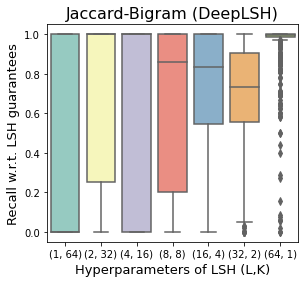

In [67]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [68]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Jaccard-bigram', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.375000
(2, 32)    0.105882
(4, 16)    0.429408
(8, 8)     0.743479
(16, 4)    0.768210
(32, 2)    0.882716
(64, 1)    0.895934
dtype: float64

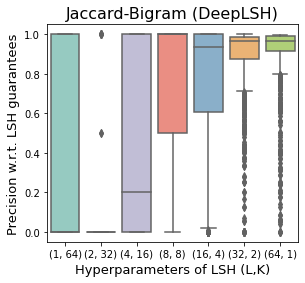

In [69]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [70]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.250000
(2, 32)    0.104869
(4, 16)    0.366449
(8, 8)     0.562410
(16, 4)    0.692292
(32, 2)    0.746133
(64, 1)    0.916426
dtype: float64

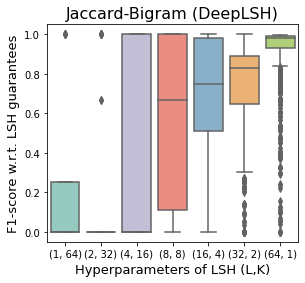

In [71]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()